# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
from importlib import reload

from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import ddpg_agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Linux_multi/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
env_info = env.reset(train_mode=True)[brain_name]

num_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size

print(f"num_agents {num_agents}, state_size: {state_size}, action_size: {action_size}")

num_agents 20, state_size: 33, action_size: 4


In [5]:
reload(ddpg_agent)

agent = ddpg_agent.Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)

print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=4, bias=True)
)
Critic(
  (fcs1): Linear(in_features=33, out_features=400, bias=True)
  (fc2): Linear(in_features=404, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)


In [6]:
def ddpg(n_episodes=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    #for i_episode in tqdm(range(1, n_episodes+1)):
    pbar = tqdm(range(1, n_episodes+1))
    for i_episode in pbar:
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = 0
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.mean(rewards)
            if np.any(dones):
                break
        scores_deque.append(score)
        scores.append(score)
        #print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        pbar.set_description('Average Score: {:.2f}, Score: {:.2f}'.format(np.mean(scores_deque), score))
        if i_episode % 10 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    pbar.close()
    return scores

  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/work/dev/udacity/deep-reinforcement-learning/.venv/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
Average Score: 0.67, Score: 1.24:   0%|          | 10/2000 [06:30<21:37:13, 39.11s/it]

Episode 10	Average Score: 0.67


Average Score: 1.52, Score: 3.65:   1%|          | 20/2000 [13:00<21:26:23, 38.98s/it]

Episode 20	Average Score: 1.52


Average Score: 3.29, Score: 6.92:   2%|▏         | 30/2000 [19:30<21:20:51, 39.01s/it]

Episode 30	Average Score: 3.29


Average Score: 4.91, Score: 10.05:   2%|▏         | 40/2000 [26:01<21:16:16, 39.07s/it]

Episode 40	Average Score: 4.91


Average Score: 6.65, Score: 17.59:   2%|▎         | 50/2000 [32:35<21:13:45, 39.19s/it]

Episode 50	Average Score: 6.65


Average Score: 8.22, Score: 16.75:   3%|▎         | 60/2000 [39:05<21:01:51, 39.03s/it]

Episode 60	Average Score: 8.22


Average Score: 9.52, Score: 18.09:   4%|▎         | 70/2000 [45:36<20:57:01, 39.08s/it]

Episode 70	Average Score: 9.52


Average Score: 10.43, Score: 16.22:   4%|▍         | 80/2000 [52:07<20:53:21, 39.17s/it]

Episode 80	Average Score: 10.43


Average Score: 11.06, Score: 11.55:   4%|▍         | 90/2000 [58:38<20:45:11, 39.12s/it]

Episode 90	Average Score: 11.06


Average Score: 11.48, Score: 14.25:   5%|▌         | 100/2000 [1:05:09<20:37:05, 39.07s/it]

Episode 100	Average Score: 11.48


Average Score: 13.23, Score: 18.66:   6%|▌         | 110/2000 [1:11:40<20:33:17, 39.15s/it]

Episode 110	Average Score: 13.23


Average Score: 14.79, Score: 20.18:   6%|▌         | 120/2000 [1:18:12<20:27:49, 39.19s/it]

Episode 120	Average Score: 14.79


Average Score: 16.27, Score: 21.61:   6%|▋         | 130/2000 [1:24:44<20:21:40, 39.20s/it]

Episode 130	Average Score: 16.27


Average Score: 17.86, Score: 27.09:   7%|▋         | 140/2000 [1:31:16<20:15:32, 39.21s/it]

Episode 140	Average Score: 17.86


Average Score: 19.17, Score: 29.56:   8%|▊         | 150/2000 [1:37:48<20:08:21, 39.19s/it]

Episode 150	Average Score: 19.17


Average Score: 20.59, Score: 30.29:   8%|▊         | 160/2000 [1:44:20<20:01:12, 39.17s/it]

Episode 160	Average Score: 20.59


Average Score: 22.06, Score: 30.94:   8%|▊         | 170/2000 [1:50:52<19:55:18, 39.19s/it]

Episode 170	Average Score: 22.06


Average Score: 23.44, Score: 31.64:   9%|▉         | 180/2000 [1:57:24<19:49:47, 39.22s/it]

Episode 180	Average Score: 23.44


Average Score: 24.77, Score: 29.22:  10%|▉         | 190/2000 [2:03:56<19:43:20, 39.23s/it]

Episode 190	Average Score: 24.77


Average Score: 26.43, Score: 32.18:  10%|█         | 200/2000 [2:10:29<19:36:57, 39.23s/it]

Episode 200	Average Score: 26.43


Average Score: 27.48, Score: 29.59:  10%|█         | 210/2000 [2:17:01<19:30:26, 39.23s/it]

Episode 210	Average Score: 27.48


Average Score: 28.68, Score: 31.18:  11%|█         | 220/2000 [2:23:33<19:22:43, 39.19s/it]

Episode 220	Average Score: 28.68


Average Score: 29.42, Score: 30.16:  12%|█▏        | 230/2000 [2:30:05<19:18:01, 39.26s/it]

Episode 230	Average Score: 29.42


Average Score: 29.69, Score: 27.87:  12%|█▏        | 240/2000 [2:36:38<19:11:03, 39.24s/it]

Episode 240	Average Score: 29.69


Average Score: 30.00, Score: 31.70:  12%|█▏        | 243/2000 [2:39:15<19:11:29, 39.32s/it]


Environment solved in 144 episodes!	Average Score: 30.00


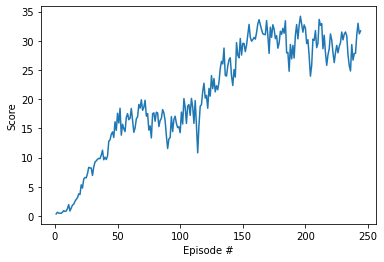

In [7]:
scores = ddpg(n_episodes=2000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [8]:
env_info = env.reset(train_mode=False)[brain_name]

num_agents = len(env_info.agents)
state_size = env_info.vector_observations.shape[1]
action_size = brain.vector_action_space_size

In [9]:
agent = ddpg_agent.Agent(num_agents=num_agents, state_size=state_size, action_size=action_size, random_seed=10)

agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

In [12]:
state = env_info.vector_observations               # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state)                      # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations      # get the next state
    reward = env_info.rewards                      # get the reward
    done = env_info.local_done                     # see if episode has finished
    score += np.mean(reward)                       # update the score
    state = next_state                             # roll over the state to next time step
    if np.any(done):                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 32.44499927479774
